# Presentación 21:

En esta presentación veremos cómo ajustar un modelo $SARIMA(p, d, q)\times(P, D, Q)_s$ con variables exógenas en Python.

## Actividad de clase:

Considere las bases de datos del petróleo brent (con nombre __petroleo_brent_historico.csv__) y de la tasa representativa del mercado (__trm_historico.csv__) que se encuentran en la carpeta DATOS del Google Drive.

1. Lea ambas bases de datos.

2. Una las dos bases de datos en una sola BD.

3. Realice un gráfico donde aparezcan ambas series de tiempo.

4. Ajuste un modelo de regresión con los errores descritos por medio de un proceso ARIMA.

5. Realice un diagnóstico del modelo y saque conclusiones.

6. Divida la BD en dos conjuntos: entrenamiento y prueba.

7. Encuentre un modelo con la función __auto_arima__.

8. Realice un diagnóstico del modelo y saque conclusiones.



In [28]:
import pandas as pd 
from matplotlib import pyplot as plt
import janitor
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

def printfuller(test_res):
    """ null hypothesis is that a unit root is present in a time series sample."""
    print("Prueba de Dickey Fuller")
    print(f"The test statistic: \t {round(test_res[0], 10)}")
    print(f"p-value: \t \t {test_res[1]}")

plt.style.use('fivethirtyeight')

## 1)

In [2]:
db1 = pd.read_csv("Data/petroleo_brent_historico.csv", decimal=",")
db2 = pd.read_csv("Data/trm_historico.csv")

In [3]:
print(db1.shape)
print(db1.dtypes)

(5000, 7)
Fecha        object
Último      float64
Apertura    float64
Máximo      float64
Mínimo      float64
Vol.         object
% var.       object
dtype: object


In [4]:
db1.head()

,Fecha,Último,Apertura,Máximo,Mínimo,Vol.,% var.
0,14.03.2022,106.90,113.15,113.15,103.49,"265,91K","-5,12%"
1,11.03.2022,112.67,110.26,113.91,107.13,"287,39K","3,05%"
2,10.03.2022,109.33,112.65,118.36,109.00,"352,34K","-1,63%"
3,09.03.2022,111.14,130.28,131.64,105.60,"521,58K","-13,16%"
4,08.03.2022,127.98,124.56,133.15,121.31,"469,99K","3,87%"


In [5]:
db1.tail()

,Fecha,Último,Apertura,Máximo,Mínimo,Vol.,% var.
4995,15.10.2002,28.50,28.36,28.78,28.30,"26,06K","0,00%"
4996,14.10.2002,28.50,28.06,28.54,27.88,"21,10K","1,82%"
4997,11.10.2002,27.99,27.90,28.10,27.85,"24,17K","0,90%"
4998,10.10.2002,27.74,28.00,28.00,27.35,"27,11K","-1,39%"
4999,09.10.2002,28.13,28.09,28.40,27.87,"31,44K","0,14%"


In [6]:
print(db2.shape)
print(db2.dtypes)

(7383, 4)
VALOR            float64
UNIDAD            object
VIGENCIADESDE     object
VIGENCIAHASTA     object
dtype: object


In [7]:
db2.head()

,VALOR,UNIDAD,VIGENCIADESDE,VIGENCIAHASTA
0,2850.98,COP,09/10/2002,09/10/2002
1,2854.04,COP,10/10/2002,10/10/2002
2,2870.63,COP,11/10/2002,11/10/2002
3,2861.16,COP,12/10/2002,15/10/2002
4,2852.99,COP,16/10/2002,16/10/2002


In [8]:
db2.tail()

,VALOR,UNIDAD,VIGENCIADESDE,VIGENCIAHASTA
7378,4268.30,COP,05/08/2022,05/08/2022
7379,4337.28,COP,06/08/2022,08/08/2022
7380,4307.09,COP,09/08/2022,09/08/2022
7381,4309.69,COP,10/08/2022,10/08/2022
7382,4273.82,COP,11/08/2022,11/08/2022


## 2) 

In [9]:
db1 = db1.clean_names()
db1.columns

Index(['fecha', 'ultimo', 'apertura', 'maximo', 'minimo', 'vol_', '%_var_'], dtype='object')

In [10]:
db1.fecha = pd.to_datetime(db1.fecha, format="%d.%m.%Y")
db1.dtypes


fecha       datetime64[ns]
ultimo             float64
apertura           float64
maximo             float64
minimo             float64
vol_                object
%_var_              object
dtype: object

In [11]:
db1

,fecha,ultimo,apertura,maximo,minimo,vol_,%_var_
0,2022-03-14,106.90,113.15,113.15,103.49,"265,91K","-5,12%"
1,2022-03-11,112.67,110.26,113.91,107.13,"287,39K","3,05%"
2,2022-03-10,109.33,112.65,118.36,109.00,"352,34K","-1,63%"
3,2022-03-09,111.14,130.28,131.64,105.60,"521,58K","-13,16%"
4,2022-03-08,127.98,124.56,133.15,121.31,"469,99K","3,87%"
...,...,...,...,...,...,...,...
4995,2002-10-15,28.50,28.36,28.78,28.30,"26,06K","0,00%"
4996,2002-10-14,28.50,28.06,28.54,27.88,"21,10K","1,82%"
4997,2002-10-11,27.99,27.90,28.10,27.85,"24,17K","0,90%"
4998,2002-10-10,27.74,28.00,28.00,27.35,"27,11K","-1,39%"


In [12]:
db2 = db2.clean_names()
db2.columns

Index(['valor', 'unidad', 'vigenciadesde', 'vigenciahasta'], dtype='object')

In [13]:
db2.rename(columns = {'vigenciadesde':'fecha'}, inplace=True)
db2.columns

Index(['valor', 'unidad', 'fecha', 'vigenciahasta'], dtype='object')

In [14]:
db2.fecha = pd.to_datetime(db2.fecha, format="%d/%m/%Y")
db1.dtypes

fecha       datetime64[ns]
ultimo             float64
apertura           float64
maximo             float64
minimo             float64
vol_                object
%_var_              object
dtype: object

In [15]:
db_full = pd.merge(db1, db2)
db_full.rename(columns = {'apertura':'brent', 'valor':'trm'}, inplace=True)
db_full.sort_values("fecha", inplace=True)
db_full.head()

,fecha,ultimo,brent,maximo,minimo,vol_,%_var_,trm,unidad,vigenciahasta
3636,2002-10-09,28.13,28.09,28.40,27.87,"31,44K","0,14%",2850.98,COP,09/10/2002
3635,2002-10-10,27.74,28.00,28.00,27.35,"27,11K","-1,39%",2854.04,COP,10/10/2002
3634,2002-10-11,27.99,27.90,28.10,27.85,"24,17K","0,90%",2870.63,COP,11/10/2002
3633,2002-10-16,28.58,28.50,28.70,28.34,"10,03K","0,28%",2852.99,COP,16/10/2002
3632,2002-10-17,27.97,27.68,28.09,27.55,"41,70K","-2,13%",2857.13,COP,17/10/2002


In [16]:
s1 = db_full.copy()
s1.set_index("fecha", inplace=True)
s1

,ultimo,brent,maximo,minimo,vol_,%_var_,trm,unidad,vigenciahasta
fecha,,,,,,,,,
2002-10-09,28.13,28.09,28.40,27.87,"31,44K","0,14%",2850.98,COP,09/10/2002
2002-10-10,27.74,28.00,28.00,27.35,"27,11K","-1,39%",2854.04,COP,10/10/2002
2002-10-11,27.99,27.90,28.10,27.85,"24,17K","0,90%",2870.63,COP,11/10/2002
2002-10-16,28.58,28.50,28.70,28.34,"10,03K","0,28%",2852.99,COP,16/10/2002
2002-10-17,27.97,27.68,28.09,27.55,"41,70K","-2,13%",2857.13,COP,17/10/2002
...,...,...,...,...,...,...,...,...,...
2022-03-04,118.11,114.23,118.98,109.62,"334,41K","6,93%",3771.77,COP,04/03/2022
2022-03-08,127.98,124.56,133.15,121.31,"469,99K","3,87%",3813.41,COP,08/03/2022
2022-03-09,111.14,130.28,131.64,105.60,"521,58K","-13,16%",3787.18,COP,09/03/2022


## 3)

<AxesSubplot:title={'center':'Serie Brent'}, xlabel='fecha'>

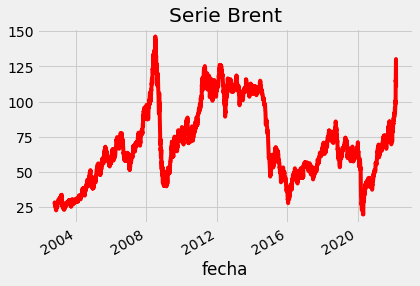

In [37]:
s1.brent.plot(title="Serie Brent", color="red")

<AxesSubplot:title={'center':'Serie TRM'}, xlabel='fecha'>

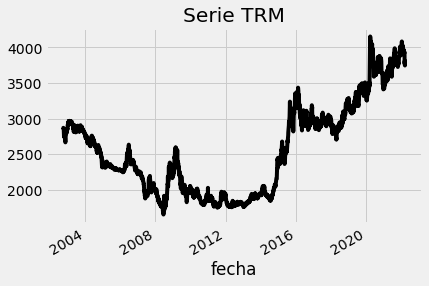

In [36]:
s1.trm.plot(title="Serie TRM", color="black")

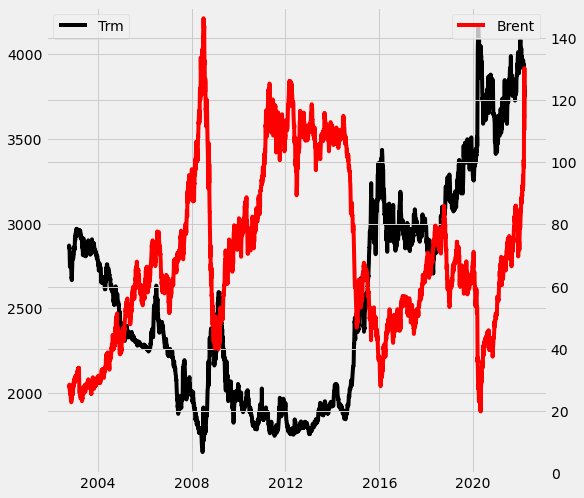

In [40]:
brent = s1.brent.values
trm = s1.trm.values
fecha = db_full.fecha.values

fig, ax1 = plt.subplots(figsize=(8, 8))
ax2 = ax1.twinx()
ax2.set_ylim(0, 150)

ax1.plot(fecha, trm, color="black", label="Trm")
ax2.plot(fecha, brent, color="red", label="Brent")
ax1.legend(loc="upper left")
ax2.legend()
plt.legend()
plt.show()

## 4)

Trataremos de plantear un modelo que pueda explicar la **TRM** a través del precio internacional del petroleo **Brent** 

/tmp/ipykernel_5755/1397121048.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


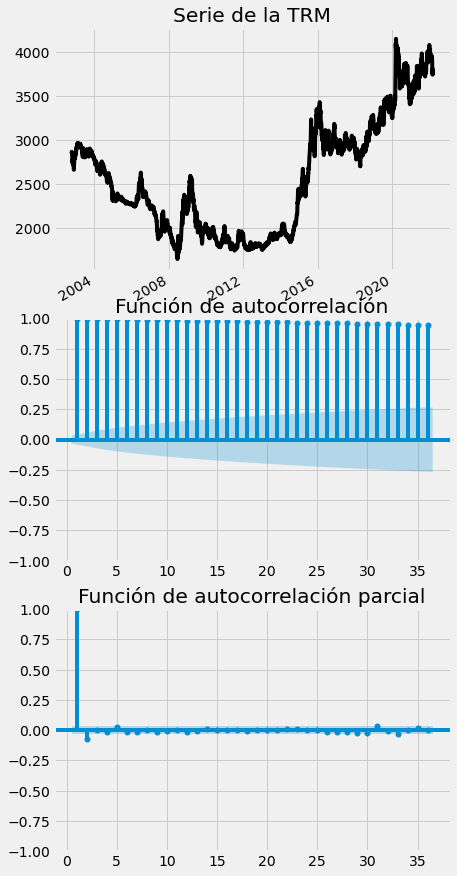

In [29]:
fig, ax = plt.subplots(3,1,figsize=(7,15))
fig.tight_layout(pad=2.5)
s1.trm.plot(ax=ax[0], title = "Serie de la TRM", xlabel="", color="black")
plot_acf(s1.trm, zero = False, title = "Función de autocorrelación", ax=ax[1])
plot_pacf(s1.trm, method="ywm", zero = False, title = "Función de autocorrelación parcial", ax=ax[2])
fig.show()

Del gráfico de la serie de tiempo no se observa que sea estacionaria, procedemos a observar la función de autocorrelación la cual presenta un decaimiento demasiado lento exponencial lo cual nos da indicios de tener que hacer una diferenciación.

Se realizará una prueba de Dickey-Fuller para verificar si es necesario realizar una diferenciación.

In [31]:
test = adfuller(s1.trm)
printfuller(test)

Prueba de Dickey Fuller
The test statistic: 	 -0.4943040666
p-value: 	 	 0.8931232351189345


Observando el p-valor = 0.8931232351189345 y con una significancia de $\alpha = 0.05$ no se rechaza. Esto quiere decir que no hay estacionaridad en la serie, lo que nos indica que debemos realizar una diferenciación.

Procedemos a diferenciar la serie. 


In [42]:
s1_aux_dif = s1.trm.diff()
s1_aux_dif

fecha
2002-10-09      NaN
2002-10-10     3.06
2002-10-11    16.59
2002-10-16   -17.64
2002-10-17     4.14
              ...  
2022-03-04   -91.18
2022-03-08    41.64
2022-03-09   -26.23
2022-03-10   -40.75
2022-03-11    39.57
Name: trm, Length: 3637, dtype: float64

/tmp/ipykernel_5755/1604739182.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


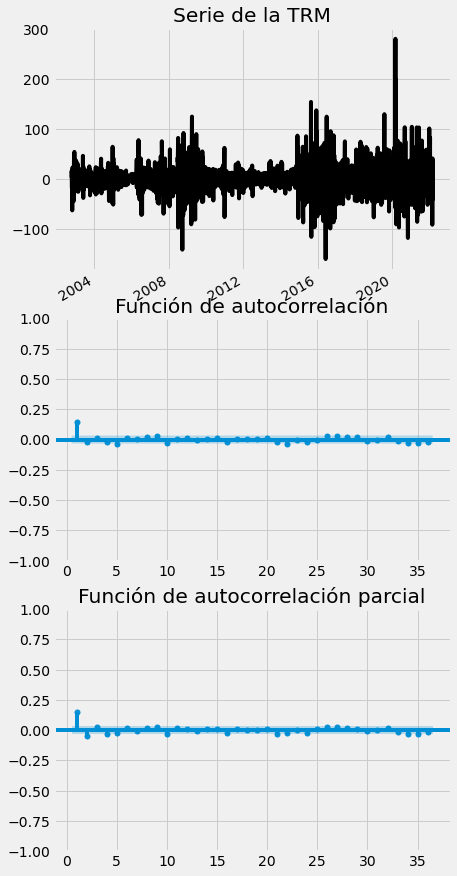

In [47]:
fig, ax = plt.subplots(3,1,figsize=(7,15))
fig.tight_layout(pad=2.5)
s1_aux_dif.plot(ax=ax[0], title = "Serie de la TRM", xlabel="", color="black")
plot_acf(s1_aux_dif.dropna(), zero = False, title = "Función de autocorrelación", ax=ax[1])
plot_pacf(s1_aux_dif.dropna(), method="ywm", zero = False, title = "Función de autocorrelación parcial", ax=ax[2])
fig.show()

Despues de hacer una diferenciación y observando la serie diferenciada se obtiene estacionaridad alrededor de 0. Se realizara una prueba Dickey-Fuller para verificar si es necesario realizar otra diferencia.

In [48]:
test = adfuller(s1_aux_dif.dropna())
printfuller(test)

Prueba de Dickey Fuller
The test statistic: 	 -27.498891546
p-value: 	 	 0.0


Observando el p-valor = 0.0 se rechaza la hipotesis nula. Esto quiere decir que hay estacionaridad en la serie.